# CI width by changing sample size for QMC and IID Beta for the Hedged (Betting) CI Method

The paper takes $X_1, X_2, \ldots \stackrel{\text{IID}}{\sim} F$ and computes a sequential confidence interval for $\mu = \mathbb{E}(X)$.

For QMC, we are going to take 

$$
X_i = \frac{1}{m} \sum_{j=1}^m T_{ij},
$$ 

where for each $i$, $\{T_{ij}\}_{j=1}^m$ is a QMC set that mimics $F$. Therefore, $X_i$ is close to $\mu$, and the sequence $\{X_i\}_{i=1}^n$ is an IID sequence based on $mn$ samples.

In this notebook, $F$ is a Beta Distribution and DigitalNetB2 (Sobol) has been used for QMC.

Importing the modules:

In [124]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import beta
from scipy.stats import multinomial
import matplotlib.cm as cm

sys.path.append(os.path.relpath("../.."))
from confseq.cs_plots import ConfseqToPlot, DataGeneratingProcess, plot_CSs
from other_bounds import hoeffding_ci, maurer_pontil_empbern_ci
from confseq.predmix import predmix_empbern_ci_seq
from confseq.betting import betting_ci_seq

figures_location = os.path.relpath("figures/")

import random
import qmcpy as qp

%matplotlib inline

The plot function used for both IID_Beta and IID_QMC_Beta:

In [125]:
def plot_func(times,lower_bound,upper_bound, title):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(times,lower_bound, color = "red")
    axs[0].plot(times,upper_bound, color = "red")
    axs[0].axhline(y=0.25, color="blue", linestyle="--")
    axs[1].plot(times,upper_bound - lower_bound, color = "red")
    axs[0].set_xlabel("sample size n") 
    axs[0].set_ylabel("Confidence Interval")
    axs[1].set_xlabel("sample size n") 
    axs[1].set_ylabel("CI Width")
    fig.text(0.45,1,title)
    fig.tight_layout()

## IID_Beta vs IID_QMC_Beta (IID replications through spawning)

Using 11 cores


/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57


IID_Beta mean =  0.25005535867011497
IID_Beta std =  0.001188100212310001
IID_Beta Upper bound at sample size N =  0.254
IID_Beta Lower bound at sample size N =  0.247
IID_Beta CI width at sample size N =  0.007000000000000006
Using 11 cores
IID_QMC_Beta mean =  0.24999892301082444
IID_QMC_Beta std =  0.0001354707865896501
IID_QMC_Beta Upper bound at sample size spawn_samples =  0.28700000000000003
IID_QMC_Beta Lower bound at sample size spawn_samples =  0.23500000000000001
IID_QMC_Beta CI width at sample size spawn_samples =  0.05200000000000002


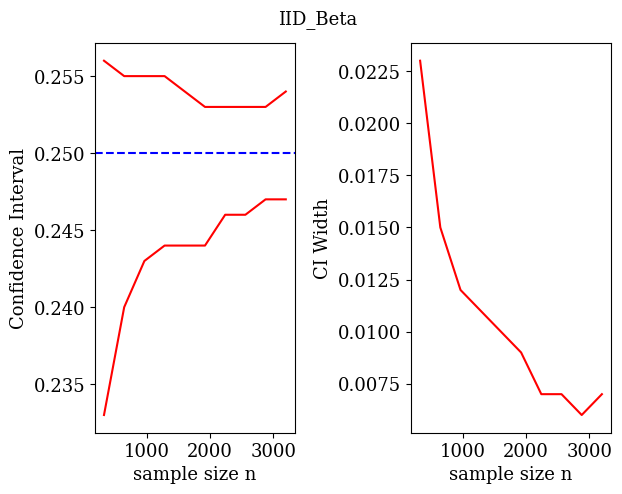

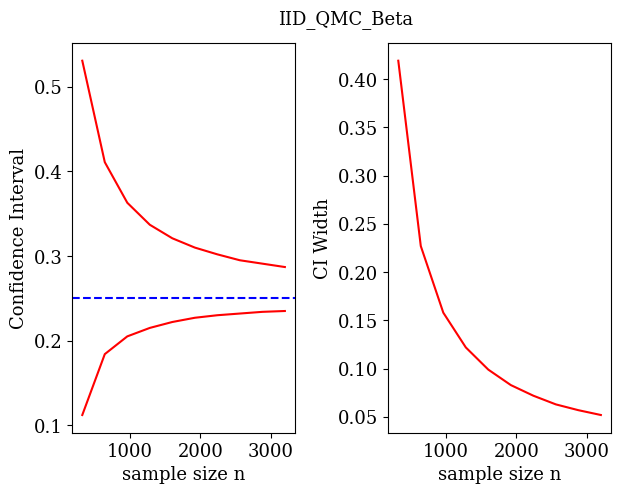

In [127]:
alpha = 0.05 # Confidence level

# The setup for IID_Beta:

N = 100 * (2**5) # The sample size
times_iid = (10 * (np.arange(1,11))) * (2**5) # The times (sample sizes) for which we'll use the lower and upper bound values
x_iid = np.random.beta(10, 30, N) # The IID_Beta samples
lower_bound_iid,upper_bound_iid = betting_ci_seq(x_iid, times=times_iid, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) # Getting the sequential CI

# Printing out the mean, std, and last upper bound,lower bound, and CI width (upper bound,lower bound, and CI width at sample size N)
print("IID_Beta mean = ", x_iid.mean())
print("IID_Beta std = ", x_iid.std()/np.sqrt(N))
print("IID_Beta Upper bound at sample size N = ", upper_bound_iid[len(upper_bound_iid) - 1])
print("IID_Beta Lower bound at sample size N = ", lower_bound_iid[len(upper_bound_iid) - 1])
print("IID_Beta CI width at sample size N = ", upper_bound_iid[len(upper_bound_iid) - 1] - lower_bound_iid[len(lower_bound_iid) - 1])


# The setup for IID_QMC_Beta:

# The function to generate the IID_QMC_Beta samples
def gen_qmc_samples_iid(distribution = qp.SciPyWrapper(discrete_distrib=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=10,b=30))
                         , spawn_samples = 11 ,gen_samples = 2**8):
    spw = distribution
    spws = spw.spawn(spawn_samples)
    samples = spws[0].gen_samples(gen_samples).flatten()
    for i in range (len(spws)- 1):
        curr_samples = spws[i + 1].gen_samples(gen_samples).flatten()
        samples = np.vstack((samples,curr_samples))
    return np.mean(samples, axis = 1)

spawn_samples = 100 # The number of IID replications
gen_samples = 2**5 # The number of samples generated per replication
times_qmc = 10 * np.arange(1,11) # The times (sample sizes) for which we'll use the lower and upper bound values
x_qmc = gen_qmc_samples_iid(spawn_samples=spawn_samples,gen_samples=gen_samples) # The IID_QMC_Beta samples
lower_bound_qmc,upper_bound_qmc = betting_ci_seq(x_qmc, times=times_qmc, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) # Getting the sequential CI

# Printing out the mean, std, and last upper bound,lower bound, and CI width (upper bound,lower bound, and CI width at sample size spawn_samples)
print("IID_QMC_Beta mean = ", x_qmc.mean())
print("IID_QMC_Beta std = ", x_qmc.std()/np.sqrt(spawn_samples))
print("IID_QMC_Beta Upper bound at sample size spawn_samples = ", upper_bound_qmc[len(upper_bound_qmc) - 1])
print("IID_QMC_Beta Lower bound at sample size spawn_samples = ", lower_bound_qmc[len(lower_bound_qmc) - 1])
print("IID_QMC_Beta CI width at sample size spawn_samples = ", upper_bound_qmc[len(upper_bound_qmc) - 1] - lower_bound_qmc[len(lower_bound_qmc) - 1])

# The plots:
plot_func(times_iid,lower_bound_iid,upper_bound_iid,"IID_Beta") # IID_Beta Plot
plot_func(times_qmc * gen_samples,lower_bound_qmc,upper_bound_qmc,"IID_QMC_Beta") # IID_QMC_Beta Plot
